# Compare clusters between different periods

- the Adjusted Rand Index (ARI)
- homogeneity
- completeness
- distances between cluster centers

Below is an explanation and an extended Python example that demonstrates how you can compare clusters between different periods using metrics such as the Adjusted Rand Index (ARI), homogeneity, completeness, and the distances between cluster centers.

> **Note:**  
> In the previous example, we focused on monitoring the clustering quality using inertia, silhouette score, and feature drift. We did not use ARI, homogeneity, or completeness because those metrics require comparing two clustering results on the **same set of samples** (or at least overlapping samples). They are very useful when you want to compare how similar two clusterings are (for example, before and after some period of drift). In many production environments, you might have a baseline clustering on a set of customers and then later reassign clusters for the same customers. In that case, these metrics can help quantify the change.

Below is an extended example that first simulates a “baseline” clustering and then simulates a slight drift by modifying the data (or using a new clustering model) for the same set of customers. We then compare the two clusterings using ARI, homogeneity, and completeness. Finally, we also compute the pairwise distances between the cluster centers to see if they have shifted significantly.


### Explanation

1. **Baseline Clustering:**  
   - We generate baseline customer data and scale the features.  
   - We fit a k-means model (with fixed random seed for reproducibility) and compute metrics such as inertia, silhouette score, and cluster distribution.

2. **Simulating Drift:**  
   - We simulate a drift in customer behavior by adding small random noise to the original features.  
   - We then **re-cluster the same customers** (now with drifted features) using a **new k-means model** (with a different random seed).

3. **Comparing Clusterings:**  
   - **Adjusted Rand Index (ARI):** Measures the similarity between the two sets of cluster labels (values close to 1 indicate high agreement).  
   - **Homogeneity & Completeness:** These scores assess whether clusters contain only members of a single class (homogeneity) and whether all members of a given class are assigned to the same cluster (completeness). In our unsupervised setting, they indicate the consistency of the cluster assignments.  
   
   These metrics require that we compare the cluster labels for the same set of customers across the two periods.
   
4. **Comparing Cluster Centers:**  
   - We compute the **Euclidean distance matrix between the baseline and new cluster centers**.  
   - Using the **Hungarian algorithm** (linear_sum_assignment), we match centers between the two clusterings to see which centers have shifted and by how much.

5. **Visualization:**  
   - A scatter plot helps **visualize the clusters** (using two dimensions) and the positions of the cluster centers from the baseline and drifted periods.

---

### When to Use These Methods

- **ARI, Homogeneity, and Completeness** are most useful when you have a set of customers that appear in both periods so that you can compare how their cluster assignments change over time.
- **Distance Between Cluster Centers** helps you assess if the underlying definitions of the clusters have shifted significantly, which might signal that re-training is necessary.

By incorporating these methods, you can gain additional insights into the stability and coherence of your clustering over time.

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

# -------------------------------
# 1. Create Baseline Customer Data (Historical Data)
# -------------------------------
np.random.seed(42)  # For reproducible data generation

baseline_data = pd.DataFrame({
    'CustomerID': np.arange(1, 1001),
    'Recency': np.random.randint(1, 100, size=1000),       # Days since last purchase
    'Frequency': np.random.randint(1, 20, size=1000),        # Number of purchases
    'Monetary': np.random.randint(10, 1000, size=1000)       # Amount spent
})
print("Baseline Customer Data:")
print(baseline_data.head())

Baseline Customer Data:
   CustomerID  Recency  Frequency  Monetary
0           1       52          2       111
1           2       93         13       995
2           3       15          6       276
3           4       72          5       876
4           5       61          1       977


In [6]:
baseline_data.shape

(1000, 4)

In [7]:
# -------------------------------
# 2. Preprocess the Data (Standardization)
# -------------------------------
features = ['Recency', 'Frequency', 'Monetary']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(baseline_data[features])

# -------------------------------
# 3. Train the Baseline k-means Clustering Model
# -------------------------------
k = 4  # Number of clusters
kmeans_baseline = KMeans(n_clusters=k, random_state=42, n_init=10)
baseline_data['Cluster'] = kmeans_baseline.fit_predict(X_scaled)

# Compute baseline metrics
baseline_inertia = kmeans_baseline.inertia_
baseline_silhouette = silhouette_score(X_scaled, baseline_data['Cluster'])
baseline_distribution = baseline_data['Cluster'].value_counts(normalize=True).sort_index()

print("\nBaseline Cluster Assignments:")
print(baseline_data[['CustomerID', 'Cluster']].head())
print("\nBaseline Inertia:", baseline_inertia)
print("Baseline Silhouette Score:", baseline_silhouette)
print("Baseline Cluster Distribution:")
print(baseline_distribution)



Baseline Cluster Assignments:
   CustomerID  Cluster
0           1        1
1           2        2
2           3        1
3           4        0
4           5        0

Baseline Inertia: 1380.5947811284873
Baseline Silhouette Score: 0.2784187648420659
Baseline Cluster Distribution:
Cluster
0    0.253
1    0.250
2    0.255
3    0.242
Name: proportion, dtype: float64


In [8]:
# -------------------------------
# 4. Simulate a New Period (Slight Drift)
# -------------------------------
# Here we simulate a drift by adding a small random noise to the features.
# We assume that we are now re-clustering the same set of customers.
baseline_data_drift = baseline_data.copy()

# Simulate drift: add some noise to each feature
for feature in features:
    baseline_data_drift[feature] = baseline_data_drift[feature] + np.random.normal(0, 5, size=baseline_data_drift.shape[0])

# Re-scale the drifted features using the same scaler (for consistency)
X_drift_scaled = scaler.transform(baseline_data_drift[features])

# Train a new k-means model on the drifted data
kmeans_new = KMeans(n_clusters=k, random_state=24, n_init=10)
baseline_data_drift['Cluster_new'] = kmeans_new.fit_predict(X_drift_scaled)

# Compute metrics for the new clustering
drift_inertia = kmeans_new.inertia_
drift_silhouette = silhouette_score(X_drift_scaled, baseline_data_drift['Cluster_new'])
drift_distribution = baseline_data_drift['Cluster_new'].value_counts(normalize=True).sort_index()

print("\nDrifted Data Cluster Assignments (first 5 rows):")
print(baseline_data_drift[['CustomerID', 'Cluster_new']].head())
print("\nDrifted Data Inertia:", drift_inertia)
print("Drifted Data Silhouette Score:", drift_silhouette)
print("Drifted Data Cluster Distribution:")
print(drift_distribution)


Drifted Data Cluster Assignments (first 5 rows):
   CustomerID  Cluster_new
0           1            3
1           2            1
2           3            2
3           4            0
4           5            0

Drifted Data Inertia: 1859.9486421573893
Drifted Data Silhouette Score: 0.24403319792772019
Drifted Data Cluster Distribution:
Cluster_new
0    0.248
1    0.242
2    0.251
3    0.259
Name: proportion, dtype: float64


In [9]:
# -------------------------------
# 5. Compare the Two Clusterings Using ARI, Homogeneity, and Completeness
# -------------------------------
# These metrics compare the similarity between two cluster labelings.
# Note: The adjusted_rand_score, homogeneity_score, and completeness_score assume that
# the same samples are being clustered.
ari = adjusted_rand_score(baseline_data['Cluster'], baseline_data_drift['Cluster_new'])
homogeneity = homogeneity_score(baseline_data['Cluster'], baseline_data_drift['Cluster_new'])
completeness = completeness_score(baseline_data['Cluster'], baseline_data_drift['Cluster_new'])

print("\nComparison between Baseline and Drifted Clusters:")
print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
print("Homogeneity: {:.3f}".format(homogeneity))
print("Completeness: {:.3f}".format(completeness))


Comparison between Baseline and Drifted Clusters:
Adjusted Rand Index (ARI): 0.497
Homogeneity: 0.469
Completeness: 0.469


In [10]:
# -------------------------------
# 6. Compare the Positions of Cluster Centers
# -------------------------------
# Compute pairwise distances between baseline cluster centers and new cluster centers.
centers_baseline = kmeans_baseline.cluster_centers_
centers_new = kmeans_new.cluster_centers_

# Calculate the Euclidean distance matrix between centers
distance_matrix = cdist(centers_baseline, centers_new, metric='euclidean')
print("\nDistance Matrix between Baseline and New Cluster Centers:")
print(distance_matrix)

# Optionally, use the Hungarian algorithm to match centers between the two models
row_ind, col_ind = linear_sum_assignment(distance_matrix)
print("\nMatching of Cluster Centers (Baseline -> New):")
for i, j in zip(row_ind, col_ind):
    print(f"Baseline center {i} is matched with new center {j} with distance {distance_matrix[i, j]:.3f}")


Distance Matrix between Baseline and New Cluster Centers:
[[0.43513462 2.29132149 2.30868117 1.9646313 ]
 [1.8452368  2.32513289 2.42423225 0.09153041]
 [2.45064513 0.2666357  2.01797488 2.14443563]
 [2.3883459  1.97883291 0.32193528 2.24854455]]

Matching of Cluster Centers (Baseline -> New):
Baseline center 0 is matched with new center 0 with distance 0.435
Baseline center 1 is matched with new center 3 with distance 0.092
Baseline center 2 is matched with new center 1 with distance 0.267
Baseline center 3 is matched with new center 2 with distance 0.322


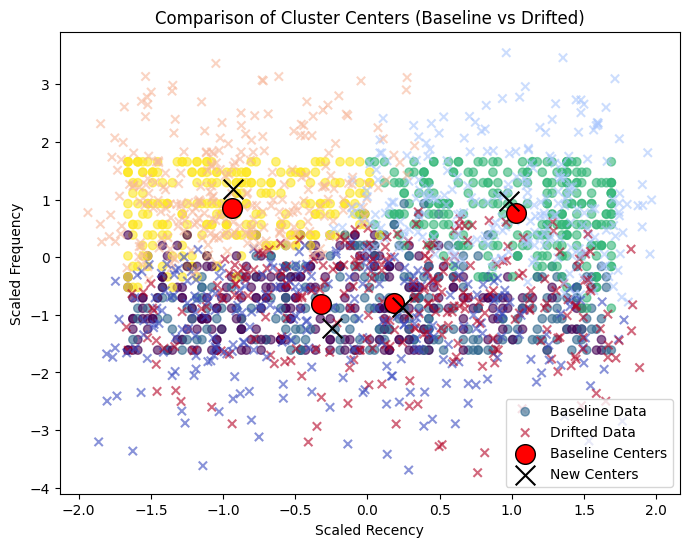

In [11]:
# -------------------------------
# 7. Visualize the Cluster Centers (for two selected dimensions)
# -------------------------------
plt.figure(figsize=(8, 6))
# We'll use the first two scaled features (Recency and Frequency) for visualization.
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=baseline_data['Cluster'], cmap='viridis', marker='o', alpha=0.6, label='Baseline Data')
plt.scatter(X_drift_scaled[:, 0], X_drift_scaled[:, 1], c=baseline_data_drift['Cluster_new'], cmap='coolwarm', marker='x', alpha=0.6, label='Drifted Data')
plt.scatter(centers_baseline[:, 0], centers_baseline[:, 1], s=200, c='red', marker='o', label='Baseline Centers', edgecolors='black')
plt.scatter(centers_new[:, 0], centers_new[:, 1], s=200, c='black', marker='x', label='New Centers')
plt.xlabel('Scaled Recency')
plt.ylabel('Scaled Frequency')
plt.title('Comparison of Cluster Centers (Baseline vs Drifted)')
plt.legend()
plt.show()
